In [ ]:
!pip install wget

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image

# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2

# Define the backward blur diffusion module
class BackwardBlurDDPM(nn.Module):
    def __init__(self):
        super(BackwardBlurDDPM, self).__init__()
        # Define the blur kernel
        self.kernel = nn.Parameter(torch.ones(1, 1, 3, 3) / 5)

    def forward(self, x):
        # Apply backward blur diffusion
        blurred_x = nn.functional.conv2d(x, self.kernel, padding=1, groups=1)
        return blurred_x

# Define the training loop
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.MSELoss()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create the U-Net model and backward blur diffusion module
model = UNet().to(device)
blur_module = BackwardBlurDDPM().to(device)

# Create the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)

# Save some example images
with torch.no_grad():
    sample = next(iter(train_loader))[0].to(device)
    output = model(sample)
    save_image(torch.cat([sample, output], dim=0), 'output.png', nrow=8)


In [ ]:
import matplotlib.pyplot as plt
plt.subplot(1, 2, 1)
plt.imshow(sample.squeeze().cpu().numpy()[0])

plt.subplot(1, 2, 2)
plt.imshow(output.squeeze().cpu().numpy()[0])


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import save_image
import cv2

**Pre_train**

In [ ]:
import wget
import zipfile
import os
import shutil

# Define the URL and file name of the dataset
dataset_url = "http://www.ee.surrey.ac.uk/CVSSP/demos/chars74k/EnglishImg.tgz"
dataset_file = "EnglishImg.tgz"

# Define the directory to store the dataset
dataset_dir = "Chars74K"

# Create the dataset directory if it doesn't exist
if not os.path.exists(dataset_dir):
    os.makedirs(dataset_dir)

# Download the dataset file
print("Downloading Chars74K dataset...")
wget.download(dataset_url, out=os.path.join(dataset_dir, dataset_file))
print("\nDataset downloaded successfully!")

# Extract the dataset

print("Extracting dataset...")
shutil.unpack_archive(os.path.join(dataset_dir, dataset_file), dataset_dir)
print("Dataset extracted successfully!")
train_data_dir = os.path.join(dataset_dir, "English/Fnt")

In [ ]:
!python preprocessing.py /content/Chars74K/English -s /content/Train_good/train

In [ ]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 1, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        )
        self.blur_module = BackwardBlurDDPM()

    def forward_blurring(self, x):
        blurred_x = self.blur_module(x)
        return blurred_x

    def forward(self, x):
        x1 = self.encoder(x)
        x2 = self.decoder(x1)
        return x2

# Define the backward blur diffusion module
class BackwardBlurDDPM(nn.Module):
    def __init__(self):
        super(BackwardBlurDDPM, self).__init__()
        # Define the blur kernel
        self.kernel = nn.Parameter(torch.ones(1, 1, 3, 3) / 7)

    def forward(self, x):
        # Apply backward blur diffusion
        blurred_x = nn.functional.conv2d(x, self.kernel, padding=1, groups=1)
        return blurred_x

    def backward_deblur_ddim(self, blurred_x):
        # Apply backward deblurring using the blurred image
        deblurred_x = nn.functional.conv_transpose2d(blurred_x, self.kernel, padding=1, groups=1)
        return deblurred_x

# Define the training loop
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    criterion = nn.MSELoss()
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

# Create the U-Net model
model = UNet().to(device)

# Create the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the model
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    train(model, device, train_loader, optimizer, epoch)

# Save some example images
with torch.no_grad():
    sample = next(iter(train_loader))[0].to(device)
    output = model(sample)
    save_image(torch.cat([sample, output], dim=0), 'output.png', nrow=8)

# Recover the image without blur
with torch.no_grad():
    blurred_sample = model.forward_blurring(sample)
    recovered_sample = model.blur_module.backward_deblur_ddim(blurred_sample)
    save_image(torch.cat([sample, recovered_sample], dim=0), 'recovered.png', nrow=8)


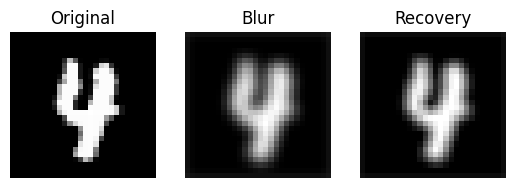

In [ ]:
import matplotlib.pyplot as plt
index=5
# Create subplots
fig, axes = plt.subplots(1, 3)

# Plot the first image
axes[0].imshow(sample.squeeze().cpu().numpy()[index])
axes[0].set_title('Original')


# Plot the second image
axes[1].imshow(recovered_sample.squeeze().cpu().numpy()[index])
axes[1].set_title('Blur')

# Plot the third image
axes[2].imshow(blurred_sample.squeeze().cpu().numpy()[index])
axes[2].set_title('Recovery')

# Remove the axes from all subplots
for ax in axes:
    ax.axis('off')